In [1]:
import numpy as np
np.set_printoptions(threshold=20, edgeitems=3)

In [2]:
f = open('ce11.fa', 'r')
gene_1 = ''
f.readline()
for line in f.readlines():
    if line[0] == '>':
        break
    gene_1 = gene_1 + line[:-1].upper()
f.close()

f = open('cb4.fa', 'r')
gene_2 = ''
f.readline()
for line in f.readlines():
    if line[0] == '>':
        break
    gene_2 = gene_2 + line[:-1].upper()
f.close()

print(len(gene_1), len(gene_2))

15072434 15455979


In [3]:
f = open('anchor.txt', 'r')
seeds = []

for line in f.readlines():
    line = line[:-3].split(' ')
    if int(line[2]) > 12000:
        seeds.append([int(line[0]), int(line[1])])
f.close()
print(len(seeds))

2193


In [4]:
def SW(gene_1, gene_2, W, g_o, g_e):
    # Initial
    num_PE = 64
    Band = 32
    tile_size = min(len(gene_1), len(gene_1))
    V = np.zeros((tile_size+1, tile_size+1))
    I = np.zeros((tile_size+1, tile_size+1))
    D = np.zeros((tile_size+1, tile_size+1))
#     Trace = np.zeros((tile_size+1, tile_size+1), dtype=int)
#     Trace_I = np.zeros((tile_size+1, tile_size+1), dtype=int)
#     Trace_D = np.zeros((tile_size+1, tile_size+1), dtype=int)
    V_max = float('-inf')
    x_max, y_max = 0, 0
    
    column_start = 1
    column_end = 1
    # Calculate
    for i in range(1, tile_size+1, num_PE):
        column_start = max(1, (i//num_PE)*num_PE+1-Band)
        column_end = min(tile_size, (i//num_PE+1)*num_PE+Band)
        column = column_start # current column
        while column <= column_end:
            # row index: i+j, column index:column
            for j in range(num_PE):
                if i+j > tile_size:
                    break
                V_nxt = V[i+j-1][column-1] + W[gene_1[i+j-1]][gene_2[column-1]]
                I[i+j][column] = max(V[i+j][column-1]+g_o, I[i+j][column-1]+g_e, 0)
                D[i+j][column] = max(V[i+j-1][column]+g_o, D[i+j-1][column]+g_e, 0)
                V[i+j][column] = max(V_nxt, I[i+j][column], D[i+j][column], 0)
                # track max score
                if V[i+j][column] >= V_max:
                    V_max = V[i+j][column]
                    x_max, y_max = i+j, column
                # track direction
#                 if V[i+j][column] == 0:
#                     Trace[i+j][column] = 0
#                 elif V[i+j][column] == V_nxt:
#                     Trace[i+j][column] = 1
#                 elif V[i+j][column] == D[i+j][column]:
#                     Trace[i+j][column] = 2
#                 elif V[i+j][column] == I[i+j][column]:
#                     Trace[i+j][column] = 3
#                 # direction of Trace_I
#                 if I[i+j][column] == V[i+j][column-1]+g_o:
#                     Trace_I[i+j][column] = 1
#                 else:
#                     Trace_I[i+j][column] = 0
#                 # direction of Trace_D
#                 if D[i+j][column] == V[i+j-1][column]+g_o:
#                     Trace_D[i+j][column] = 1
#                 else:
#                     Trace_D[i+j][column] = 0
            # if stripe end
            column += 1
    return V_max, x_max, y_max

In [5]:
W = {'A': {'A':  91, 'C': -90, 'G': -25, 'T':-100, 'N': -30},
     'C': {'A': -90, 'C': 100, 'G':-100, 'T': -25, 'N': -30},
     'G': {'A': -25, 'C':-100, 'G': 100, 'T': -90, 'N': -30},
     'T': {'A':-100, 'C': -25, 'G': -90, 'T':  91, 'N': -30},
     'N': {'A': -30, 'C': -30, 'G': -30, 'T': -30, 'N': -30}}
g_o = -430
g_e = -30

In [6]:
# Check anchor correctness
for i in seeds[0:10]:
    cut_1 = gene_1[i[0]-320:i[0]]
    cut_2 = gene_2[i[1]-320:i[1]]
    score, x, y = SW(cut_1, cut_2, W, g_o, g_e)
    print(score)

19948.0
20695.0
19846.0
14911.0
14041.0
15235.0
15777.0
14582.0
12544.0
15474.0


In [7]:
def NW(gene_1, gene_2, W, g_o, g_e):
    # Initial
    num_PE = 64
    tile_size = min(len(gene_1), len(gene_1))
    y_drop = 9430
    
    V = np.zeros((tile_size+1, tile_size+1))
    V = V + float('-inf')
    V[0][0] = 0
    I = np.zeros((tile_size+1, tile_size+1))
    I = I + float('-inf')
    I[0][0] = 0
    D = np.zeros((tile_size+1, tile_size+1))
    D = D + float('-inf')
    D[0][0] = 0

    for i in range(1, tile_size+1):
        V[0, i] = g_o + (i-1)*g_e
        V[i, 0] = g_o + (i-1)*g_e
        D[0, i] = float('-inf')
        D[i, 0] = g_o + i*g_e
        I[0, i] = g_o + i*g_e
        I[i, 0] = float('-inf')
    
    # Direction matrix, 0:no compute, 1:top-left, 2:top, 3:left
    Trace = np.zeros((tile_size+1, tile_size+1), dtype=int)
    # When direction = 'left' or 'top', we needs to trace next direction on 'Trace_I' or 'Trace_D' instead of 'Trace'
    # 0:from Trace_I or Trace_D (extend gap), 1:from Trace (new gap)
    Trace_I = np.zeros((tile_size+1, tile_size+1), dtype=int)
    Trace_D = np.zeros((tile_size+1, tile_size+1), dtype=int)
    
    # Calculate
    column_start = 1
    column_end = 1
    V_max = float('-inf')
    V_max_local = float('-inf')
    x_max, y_max = 0, 0
    x_max_local, y_max_local = 0, 0

    for i in range(1, tile_size+1, num_PE):
        column = column_start # current row
        V_max_local = float('-inf')
        # print(f"{(i+3)//4}'th stripe start at column {column}")
        stripe_end = False
        while not stripe_end:
            # row index: i+j, column index:column
            for j in range(num_PE):
                if i+j > tile_size:
                    break
                # print(i+j, column)
                V_nxt = V[i+j-1][column-1] + W[gene_1[i+j-1]][gene_2[column-1]]
                I[i+j][column] = max(V[i+j][column-1]+g_o, I[i+j][column-1]+g_e)
                D[i+j][column] = max(V[i+j-1][column]+g_o, D[i+j-1][column]+g_e)
                V[i+j][column] = max(V_nxt, I[i+j][column], D[i+j][column])
                # print(i+j, column, V[i+j][column])
                # track max score
                if V[i+j][column] >= V_max:
                    V_max = V[i+j][column]
                    x_max, y_max = i+j, column
                # local minimum for stripe end
                if V[i+j][column] >= V_max_local:
                    V_max_local = V[i+j][column]
                    x_max_local, y_max_local = i+j, column
                # track direction
                if V[i+j][column] == V_nxt:
                    Trace[i+j][column] = 1
                elif V[i+j][column] == D[i+j][column]:
                    Trace[i+j][column] = 2
                elif V[i+j][column] == I[i+j][column]:
                    Trace[i+j][column] = 3
                # direction of Trace_I
                if I[i+j][column] == V[i+j][column-1]+g_o:
                    Trace_I[i+j][column] = 1
                else:
                    Trace_I[i+j][column] = 0
                # direction of Trace_D
                if D[i+j][column] == V[i+j-1][column]+g_o:
                    Trace_D[i+j][column] = 1
                else:
                    Trace_D[i+j][column] = 0
            # if stripe end
            # working number of PEs amy < total number when last stripe
            PEs = min(num_PE, tile_size-i+1)
            max_in_PEs = max([V[i+j][column] for j in range(PEs)])
            # print(max_in_PEs, V_max, V_max-y_drop)
            # needs to end far than max_y
            if column < column_end:
                pass
            elif column == tile_size:
                stripe_end = True
                column_end = column
                # print(f"{(i+3)//4}'th stripe ended at column {column}")
            elif (max_in_PEs < V_max_local-y_drop):
                stripe_end = True
                column_end = column
                # print(f"{(i+3)//4}'th stripe ended at column {column}")
            # PE shift to next column
            column += 1
        # next stripe start position
        column_start_old = column_start
        min_in_PEs = min([V[i+j][column_start] for j in range(PEs)])
        early_end = False
        while min_in_PEs < V_max_local-y_drop:
            column_start += 1
            if column_start > tile_size:
                early_end = True
                break
            min_in_PEs = min([V[i+j][column_start] for j in range(PEs)])
            # print('find next start:', i, column_start, V_max_local-y_drop, min_in_PEs)
        # print(V_max, V_max_local, column_start)
        # all score in stripe < maximum-y_drop
        if early_end:
            break
    return V_max, x_max, y_max, V, Trace, Trace_I, Trace_D

In [8]:
def trace(gene_1, gene_2, x_max, y_max, Trace, Trace_I, Trace_D):
    seq_1 = ''
    seq_2 = ''
    result = ''
    # which matirx are we tracking now
    target_matrix = 'T'

    x, y = x_max, y_max
    while(x != 0) and (y != 0):
        if target_matrix == 'T':
            # print('T', Trace[x][y], x, y)
            if Trace[x][y] == 1:
                seq_1 = gene_1[x-1] + seq_1
                seq_2 = gene_2[y-1] + seq_2
                if gene_1[x-1] == gene_2[y-1]:
                    result = '|' + result
                else:
                    result = ' ' + result
                x, y = x-1, y-1
            # if direction = top, move to Trace_D
            elif Trace[x][y] == 2:
                if Trace_D[x][y] == 0:
                    target_matrix = 'D'
                seq_1 = gene_1[x-1] + seq_1
                seq_2 = '-' + seq_2
                result = ' ' + result
                x, y = x-1, y
            # if direction = left, move to Trace_I
            elif Trace[x][y] == 3:
                if Trace_I[x][y] == 0:
                    target_matrix = 'I'
                seq_1 = '-' + seq_1
                seq_2 = gene_2[y-1] + seq_2
                result = ' ' + result
                x, y = x, y-1
        elif target_matrix == 'D':
            # print('D', Trace_D[x][y], x, y)
            # move to Trace if reach gap origin
            if Trace_D[x][y] == 1:
                target_matrix = 'T'
            seq_1 = gene_1[x-1] + seq_1
            seq_2 = '-' + seq_2
            result = ' ' + result
            x, y = x-1, y
        elif target_matrix == 'I':
            # print('I', Trace_I[x][y], x, y)
            # move to Trace if reach gap origin
            if Trace_I[x][y] == 1:
                target_matrix = 'T'
            seq_1 = '-' + seq_1
            seq_2 = gene_2[y-1] + seq_2
            result = ' ' + result
            x, y = x, y-1

    width = 100
    parts = len(seq_1)//width + 1
    # print(f'Score: {V_max}, Position: {x_max, y_max}')
    for i in range(parts):
        print(seq_1[i*width:min(i*width+width, len(seq_1))])
        print(result[i*width:min(i*width+width, len(result))])
        print(seq_2[i*width:min(i*width+width, len(seq_2))])
        print('')

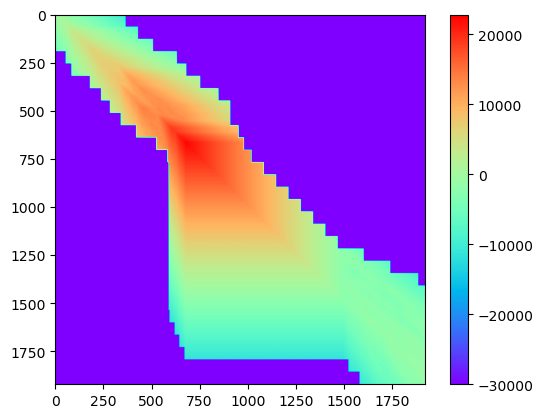

Score: 22831.0 Position: (666, 678)
ATCAAATAGCATTAAGTTTCCCAATTAGAAAAACAATAAGAGATTGTGGTTTAGATCTTATGATTAGTGATGAAGGTTTTGTAGTAAGAGTAATTAAGAA
| ||||| || |||| |||   ||     || |   | |  ||||||    |||| || |||||||||||||| |||||||  |||| |  |||| | | 
ACCAAATTGCGTTAAATTTTGAAACACAGAAGATTGTGAATGATTGTAACATAGACCTAATGATTAGTGATGAGGGTTTTGCTGTAAAAAGAATTGAAAG

TCATAATCGCTTTCCAAAACAAATACCTATCGCAATTTC------TACTCGAGAAGAATTACAACAACAAAGACATAAGCAGCAATTAGAAGAATATGAG
   | |    | ||||| ||| || |||||  ||||  |      | ||| | ||||  | ||||  ||||||||  | |||         ||  | || 
ATCTCAATATTCTCCAAGACACATTCCTATTCCAATCCCATCATATTCTCAACAAGATATTCAACGTCAAAGACAACAACAG---------GAGGACGAC

AAAAGAAATCAAGAAATTTTAAGAAGAGAAGAAGAAATAAAACAACAAAATCAAGAGAGAGAAAAACAAATCAATGATGATTTTGAAAAGAGAAAACAAG
| ||||||               | | ||| ||||   | ||||   ||| |  |||  ||||               |||  |   |   |  | ||||
AGAAGAAA---------------ACGTGAACAAGAGGAACAACAGAGAAAGCGGGAGCAAGAA---------------GATAGTAGGAGACGGGATCAAG

AAAAACTAAAAAGA------GAAGAAGAAATGAAACAACAAAATCAAGAGAG

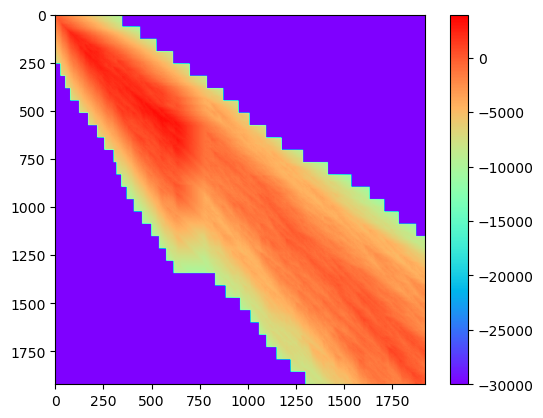

Score: 3945.0 Position: (535, 548)
GATTCTTCAATACTGATGATCAAACTAACACTTCTAGTTATGTAATTATTACCCCTAAAAAAGAAGATAAAATAGAGTTAGTAGATAATATAAAAACTTA
||||||| ||| |||           ||  ||||||||||| |||||||     |  || || ||  |||| ||||  | ||||| |||   | ||    
GATTCTTTAATGCTGG---------AAATGCTTCTAGTTATTTAATTATGGGTTCAGAAGAAAAACCTAAAGTAGAACTTGTAGAAAATTGTAGAAAGCC

TAATACAACATCAAATACAGAATCTAACATAAAAACTTCTAGTATTAAAGAATCAAATATAGAAACTTCTAGTTTAAAAGTATCTAAGAAAATAGAAGGA
| |||  |    |  || |||                  |||| ||||  | |||| || |||   ||    ||| |  ||||  ||| ||||||||   
TGATATGA----ACCTATAGA------------------TAGTCTTAATAAGTCAATTAGAGAG--TTGGTATTTGATGGTATGAAAG-AAATAGAACTT

TCTGGAAAT-AAAATGAATAAGAAATCTAAAAAATCTGATGATAAAAAGATATCAAAAGCTAATAATAA-----------------------------TT
 |||    | || ||| |   |   ||| |   |    ||  | | |   ||| ||   | | | || |                             ||
CCTGATGTTGAAGATGTAGTTGGGGTCTTAGCTACAAAATATTTAGACTTTATGAACGCCCATTTATCACTGGAATCTGCATTATATCTTTTGGATTCTT

TCTTAAAAGTTCTTAAAAGTGGATCAGGTTTTAAGAGAATTTAGATGATATGT

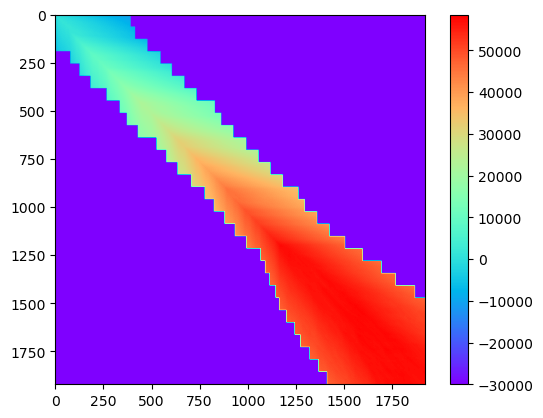

Score: 58581.0 Position: (1742, 1728)
AAAACTACCATATGATAATTTTGAGTTTGAGAAAAATGTTAATGAGATAAAAGATATTGAAAAATATTTAAATGAAATAGAATTAAAAGAAAAAGGATGC
 ||| ||||||||||| | || || || |   || |  |||                | | ||||   || ||||  | |  | |||||||||||| |||
GAAATTACCATATGATGAATTCGAATTCGTTGAAGACTTTA--------------CCTTAGAAATG-ATAGATGATCTTGTTTCAAAAGAAAAAGGTTGC

ATATTGGAGGTGGATTTAGACTATCCAGTTGAGCTTCATGATAGGCATAATGATCTACCATTTTGTCCAGAAAATAAGCTTGTTGGAACCACTAATAAAT
||| | || || |||||||| |||||||  ||  | |||||||  ||||||||| |||| || |||||||| ||||| |  |||||| | || |||||| 
ATACTAGAAGTAGATTTAGATTATCCAGAAGAATTACATGATAAACATAATGATTTACCTTTCTGTCCAGAGAATAAACGAGTTGGATCTACCAATAAAC

TAATTAGTGATTTATCTAATAAAACCAAATATGTGATTCATTATAAAAATTTAAAGCAAGTATTAAAAAATGGAATGGTTTTGAAGAAAATTCATAGAGT
|||| | ||||||   |   || |  || ||||| || |||||||||    |   |||||| ||| |  ||||| |  ||||||||||||||||||||||
TAATAAATGATTTTAGTCCAAAGAGAAATTATGTAATACATTATAAAGCCCTTTTGCAAGTTTTAGATCATGGATTAATTTTGAAGAAAATTCATAGAGT

TGTGAGTTTTAGGGAATCTAATTGGTTGGCTCCATATATAGAGCTAAATA

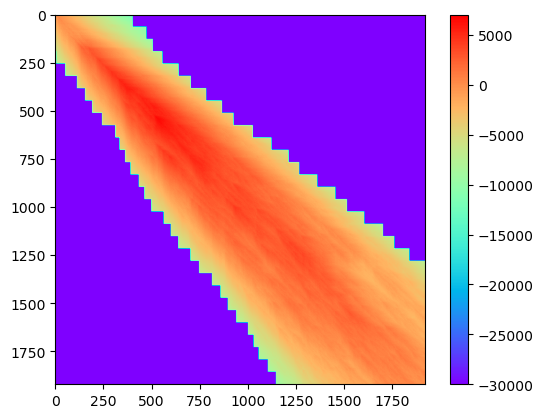

Score: 7017.0 Position: (544, 535)
TAAGAAAGGTGTTGGTCAGACACAGTGGCATTCAGGTTGAGTAGTTTGATAA-GAGAATGATGTGTCATCTTGTTC-TGTCGTCACACTGAGTTTCTTCC
| | ||  |||||||| |   ||| | |  ||    ||  || ||||  | | |    ||| |  | || || ||| |||   | |   |||  | ||  
TGAAAAGAGTGTTGGTTA---ACACTTGATTT----TTTTGTCGTTTCTTCATGGTTCTGACGGTTGATTTTTTTCATGTTTGCTCGACGAGAATTTTTG

ATCAA-------GATTTTTTCTCGAGAATTTTTCCATTTTTTTTCTCGAATTTTTTCAGATTTTTTCTCGATTTTTCTTGCATATTTTGAGAGGTAATGA
    |       |||||||||       ||||| |||  ||||| |    ||||||  |||||||| || ||||||||||||||||||         |  
GCTGATTTTTCTGATTTTTTC----AGTTTTTTTCATGATTTTTTTTCGTTTTTTTTCGATTTTTTTTCAATTTTTCTTGCATATTTT---------TCG

GATCTCTTTAGCTTATTTGATCCAAGTTTGTGTGTGGAGTCAAACTTTTGTGTTAAGTTTT-----CAAGACAGGCACACTACCACTTGACTATGATGG-
|||||| |||  |   |    |  || || || |||| ||   |  ||| |   |   ||      |||||||| | |  ||||| |     ||||    
GATCTCATTAAGTGGATAATCCTGAGCTTTTGAGTGGGGTTCGAACTTTCTACCA---TTCAAACACAAGACAGACGCTTTACCATTCTGACATGAGAAC

AAGCTGATAAGAAATTCTTGGAGTTGGTTAAGAAGTGGGGAG--TCTTATCAG

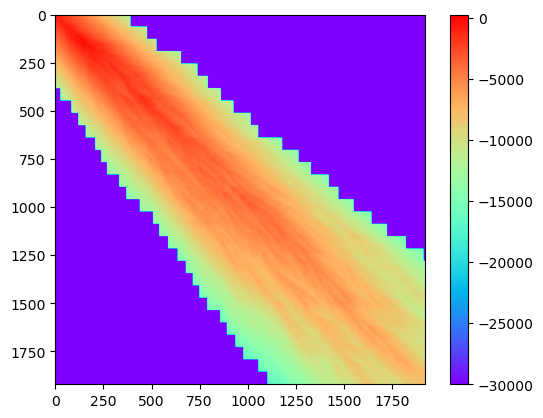

Score: 259.0 Position: (131, 136)
GTGAGTGAAGTGGGCGGAGTCGAGTTGTTCGTTTTTTTGCTACCCTTCTCGCGCCCCGCAGCATCGTGTTGCGTCGCCGTTGTC--------GCAGTCCT
 |     || |  |     | || |  |||    | |    |  || | | | |  ||| ||      || || | |||    |        ||||  | 
CT---CTAACTTTGATTTATAGACTCCTTCCAAGTCTCTTAAGACTCCGCCCACTTCGCCGCGAAACTTTTCGGCTCCGCCCACTTTCGAGAGCAGCTCC

TCTTCGCCGCCGTCACACTTCTGTGTCTCGTCTTCTTCA
 ||||  || || |   ||    |  |   ||| || ||
ACTTCTTCGACGGCGAGCTCTCATTCCATTTCTCCTCCA



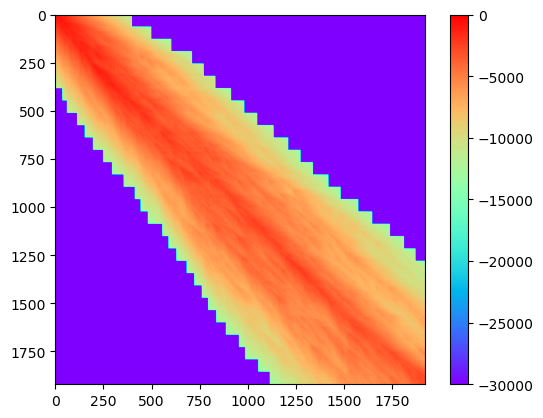

Score: -25.0 Position: (1, 1)
C
 
T



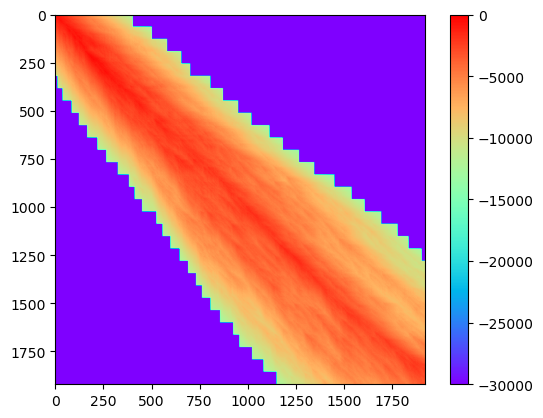

Score: 1.0 Position: (223, 188)
CCTGGTAGGTGGTGGCCCCCATTGGTGGTACGTCATAATCCAGTCTCAAGTATCAGCTTACGAGTGCATTCCTTCTTTATTTGTCCTTCTGGCTCCCATA
 ||  || |     |||| | | |  |   ||  |   | | |   |      |  ||| |||| |||   |  |||   ||   |  |  |||| |   
TCTCTTAAGACTCCGCCCACTTCGCCG---CGAAACTTTTCGGCTCC----GCCCACTTTCGAGAGCAGCTCCACTT--CTTCGACGGCGAGCTCTC---

GATTCTATTTTCTTTTTTTTTCTTGCTTTTTCGTTTTTCTTCCATTTTTGTTGAGTCGAAGAAAAGAAAAAAGAAATAAAAAAGCTTCCCCTTCCTTTTT
 |||| ||||    |         |  ||  |||| |||  |||  |    ||                |||| |  ||| | ||||| ||   || | |
-ATTCCATTTCTCCTCCACACAGAGTCTTGACGTTCTTC--CCAAGTACTCTG----------------AAAGCAGCAAATATGCTTCACCGAACTGTCT

GTTCCCTTTCCTTGCTCCT
 ||    |   |||  |||
ATTTGGCTCTTTTGGCCCT



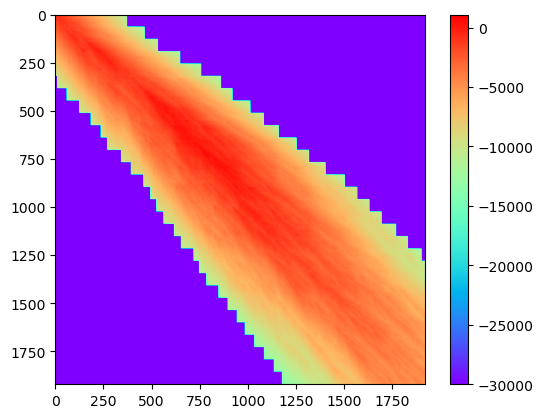

Score: 1081.0 Position: (709, 768)
CCACACCTAGCATCTGAATTC-------AGTGTAACTTTACACACACACACACACACACACACGCACACACTTTTCAACATCGGGTGCTGATG-------
| | || |  |  ||     |       || | | ||  ||     |     |   | | ||  |     ||  || |||  | ||  ||| |       
CGAAACTTTTCGGCTCCGCCCACTTTCGAGAGCAGCTCCACTTCTTCGACGGCGAGCTCTCATTCCATTTCTCCTCCACACAGAGTCTTGACGTTCTTCC

------------AAGATGCTACTACACATCTTCTGATTCCTCATCT--TTCTCTTCGTATTCATTGTCGTGTTGTCTGCCACTCT--CAATCACTCTTGA
            |||  || | ||  | ||  |  | |    || |   ||| || |   |||| ||||| | | |  |  |     | |||| ||||||
CAAGTACTCTGAAAGCAGCAAATATGCTTCACCGAACTGTCTATTTGGCTCTTTTGGCCCTCATCGTCGTCTCGGCCACGGCCTCGGCCATCAGTCTTGA

-----CTGATCTTTTTTTAA----TGAATGAAAAAAAAATCATCAATTTTAATGATTTCATTTTATTAATCTGCGCTTTTCGTTTCCAGC---CTTTTGT
     | | ||  |||| ||    |   | |  | ||    ||  | | ||   |   |||||| | ||  | |  || |  |    ||    || ||| 
GCAAGCCGGTCAGTTTTGAAAAGTTTTGTTATGAGAAGGCTATTTAATCTAG-AAGGGCATTTTCTCAAAATACCGTTGTGTTCAATAGAGCGCTCTTGC

TAGTGCTTTAAATATTTTGACTTGG-------TACTTACATT----ATAGTCG

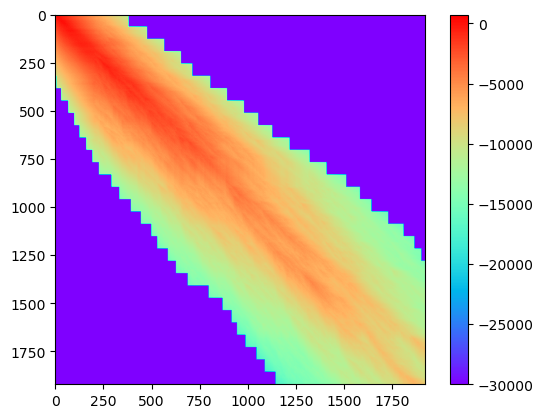

Score: 731.0 Position: (11, 11)
CATTAGATCCT
  |||||||||
TCTTAGATCCT



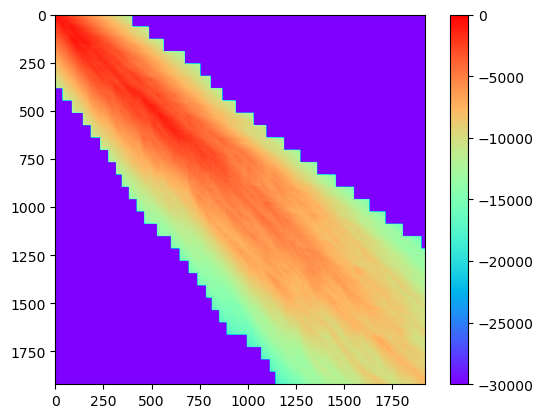

Score: -90.0 Position: (1, 1)
G
 
T



In [9]:
import matplotlib.pyplot as plt
tile_size = 1920

for i in seeds[0:10]:
    cut_1 = gene_1[i[0]:i[0]+tile_size]
    cut_2 = gene_2[i[1]:i[1]+tile_size]
#     print(cut_1[0:10])
#     print(cut_2[0:10])
    V_max, x_max, y_max, V, Trace, Trace_I, Trace_D = NW(cut_1, cut_2, W, g_o, g_e)
    V = np.clip(V, -30000, 100000)
    plt.imshow(V, cmap='rainbow')
    plt.colorbar()
    plt.show()
    print('Score:', V_max, f'Position: {x_max, y_max}')
    
    trace(cut_1, cut_2, x_max, y_max, Trace, Trace_I, Trace_D)

In [10]:
np.set_printoptions(threshold=20, edgeitems=4)
print(V[0:10, 0:10])
print(Trace[0:10, 0:10])

[[   0. -430. -460. -490. ... -580. -610. -640. -670.]
 [-430.  -90. -455. -360. ... -640. -670. -700. -730.]
 [-460. -339. -190. -545. ... -519. -665. -579. -609.]
 [-490. -550. -248. -215. ... -524. -609. -765. -679.]
 ...
 [-580. -640. -519. -333. ... -515. -553. -659. -749.]
 [-610. -489. -740. -609. ... -256. -540. -462. -568.]
 [-640. -700. -398. -765. ... -593. -346. -640. -562.]
 [-670. -730. -609. -423. ... -633. -683. -446. -740.]]
[[0 0 0 0 ... 0 0 0 0]
 [0 1 1 1 ... 1 3 1 1]
 [0 1 1 1 ... 1 1 1 1]
 [0 2 1 1 ... 1 1 1 1]
 ...
 [0 2 1 1 ... 1 1 1 1]
 [0 1 1 1 ... 1 1 1 1]
 [0 2 1 1 ... 1 1 1 1]
 [0 2 1 1 ... 1 1 1 1]]


In [11]:
def GACT_extend(gene_1, gene_2, seed, W, g_o, g_e):
    tile_size = 1920
    cut_1 = gene_1[seed[0]:seed[0]+tile_size]
    cut_2 = gene_2[seed[1]:seed[1]+tile_size]
    V_max, x_max, y_max, V, Trace, Trace_I, Trace_D = NW(cut_1, cut_2, W, g_o, g_e)
    V = np.clip(V, -30000, 100000)
    plt.imshow(V, cmap='rainbow')
    plt.colorbar()
    plt.show()
    # print(cut_1[x_max-10:x_max], cut_2[y_max-10:y_max])
    new_seed = [x_max+seed[0], y_max+seed[1]]
    # print(gene_1[new_seed[0]-10:new_seed[0]], gene_2[new_seed[1]-10:new_seed[1]])
    print('Score:', V_max, f'Start: {seed[0], seed[1]},End: {x_max+seed[0], y_max+seed[1]}')
    # print(x_max, y_max)
    
    trace(cut_1, cut_2, x_max, y_max, Trace, Trace_I, Trace_D)
    
    if V_max > 0:
        GACT_extend(gene_1, gene_2, new_seed, W, g_o, g_e)
    


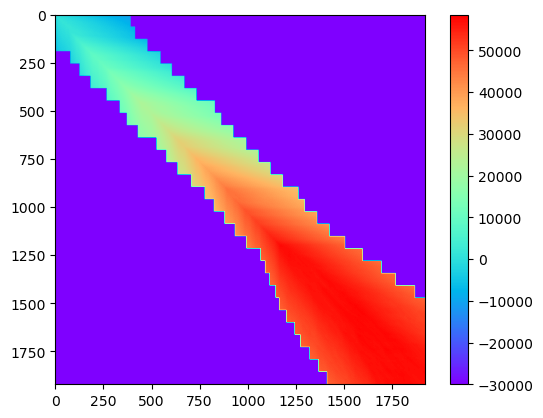

Score: 58581.0 Start: (10316815, 6177),End: (10318557, 7905)
AAAACTACCATATGATAATTTTGAGTTTGAGAAAAATGTTAATGAGATAAAAGATATTGAAAAATATTTAAATGAAATAGAATTAAAAGAAAAAGGATGC
 ||| ||||||||||| | || || || |   || |  |||                | | ||||   || ||||  | |  | |||||||||||| |||
GAAATTACCATATGATGAATTCGAATTCGTTGAAGACTTTA--------------CCTTAGAAATG-ATAGATGATCTTGTTTCAAAAGAAAAAGGTTGC

ATATTGGAGGTGGATTTAGACTATCCAGTTGAGCTTCATGATAGGCATAATGATCTACCATTTTGTCCAGAAAATAAGCTTGTTGGAACCACTAATAAAT
||| | || || |||||||| |||||||  ||  | |||||||  ||||||||| |||| || |||||||| ||||| |  |||||| | || |||||| 
ATACTAGAAGTAGATTTAGATTATCCAGAAGAATTACATGATAAACATAATGATTTACCTTTCTGTCCAGAGAATAAACGAGTTGGATCTACCAATAAAC

TAATTAGTGATTTATCTAATAAAACCAAATATGTGATTCATTATAAAAATTTAAAGCAAGTATTAAAAAATGGAATGGTTTTGAAGAAAATTCATAGAGT
|||| | ||||||   |   || |  || ||||| || |||||||||    |   |||||| ||| |  ||||| |  ||||||||||||||||||||||
TAATAAATGATTTTAGTCCAAAGAGAAATTATGTAATACATTATAAAGCCCTTTTGCAAGTTTTAGATCATGGATTAATTTTGAAGAAAATTCATAGAGT

TGTGAGTTTTAGGGAATCTAATTGGTT

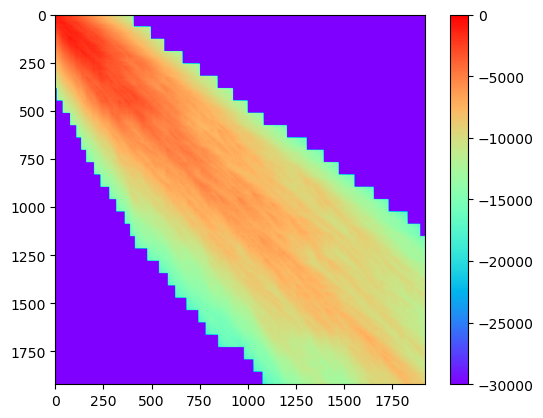

Score: -100.0 Start: (10318557, 7905),End: (10318558, 7906)
A
 
T



In [12]:
GACT_extend(gene_1, gene_2, seeds[2], W, g_o, g_e)